In [405]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install keras tensorflow

     |████████████████████████████████| 378kB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 421.8MB 50kB/s s eta 0:00:01 |                                | 51kB 4.1MB/s eta 0:01:42     |                                | 1.4MB 4.0MB/s eta 0:01:45     |▍                               | 4.8MB 4.0MB/s eta 0:01:44     |▍                               | 5.0MB 4.0MB/s eta 0:01:44     |▍                               | 5.3MB 4.0MB/s eta 0:01:44     |▌                               | 6.7MB 4.0MB/s eta 0:01:44     |▌                               | 7.1MB 4.0MB/s eta 0:01:44     |█                               | 13.0MB 12.5MB/s eta 0:00:33     |█                               | 13.3MB 12.5MB/s eta 0:00:33     |█▍                              | 17.8MB 5.6MB/s eta 0:01:13     |█▍                              | 18.0MB 5.6MB/s eta 0:01:13     |███                             | 39.1MB 9.7MB/s eta 0:00:40     |████▍                           | 57.8MB 7.0MB/s eta 0:00:52     |████▋       

     |████████████████████████████████| 71kB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 61kB 11.1MB/s eta 0:00:01
     |████████████████████████████████| 307kB 3.6MB/s eta 0:00:01
     |████████████████████████████████| 92kB 14.1MB/s eta 0:00:01
     |████████████████████████████████| 92kB 17.4MB/s eta 0:00:01
     |████████████████████████████████| 163kB 6.4MB/s eta 0:00:01
     |████████████████████████████████| 81kB 13.3MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=f7a0ee8369bc65b802e9c7703ffbae0c0351f1d0857e6ebe82e757d416479f63
  Stored in directory: /home/jovyan/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4831 sha256=818ef5d2a224f738b8f8340f16bea53ebeffbe8d3b70109a08ef3140560cd1ed
  Stored in directory: /home/jovyan/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [581]:
data = pd.read_csv('usd_gbp20y.csv')

In [582]:
data['date'] = pd.to_datetime(data['date'])

In [583]:
data['dow'] = data.date.dt.dayofweek
data['day'] = data.date.dt.day

In [584]:
data['rate_mid'] = (data['rate_open']+data['rate_close']) / 2
data["idc"] = data["rate_close"] - data["rate_open"]
data["pidc"] = (data["idc"] / data["rate_open"]) *100
data["didc"] = [1 if x > 0 else 0 for x in data['pidc']]

In [585]:
data = data.dropna()
data.head()

,day,date,rate_open,rate_high,rate_low,rate_close,dow,rate_mid,idc,pidc,didc
0,11.0,2020-03-11,0.7744,0.7785,0.7706,0.7771,2.0,0.77575,0.0027,0.348657,1
1,10.0,2020-03-10,0.7622,0.7762,0.7615,0.7746,1.0,0.76840,0.0124,1.626870,1
2,9.0,2020-03-09,0.7674,0.7679,0.7575,0.7622,0.0,0.76480,-0.0052,-0.677613,0
4,6.0,2020-03-06,0.7719,0.7723,0.7661,0.7663,4.0,0.76910,-0.0056,-0.725483,0
5,5.0,2020-03-05,0.7769,0.7776,0.7711,0.7720,3.0,0.77445,-0.0049,-0.630712,0


In [586]:
data['rate_open'] = 1/data['rate_open']
data['rate_high'] = 1/data['rate_high']
data['rate_close'] = 1/data['rate_close']
data['rate_low'] = 1/data['rate_low']

In [587]:
data = data.iloc[::-1]

In [588]:
rate_open = data['rate_open'].values

In [589]:
data.head()

,day,date,rate_open,rate_high,rate_low,rate_close,dow,rate_mid,idc,pidc,didc
6320,3.0,2000-01-03,1.614726,1.614466,1.639613,1.636126,0.0,0.61525,-0.0081,-1.307928,0
6319,4.0,2000-01-04,1.635858,1.631588,1.641228,1.636126,1.0,0.61125,-0.0001,-0.016359,0
6318,5.0,2000-01-05,1.637197,1.635323,1.645007,1.642576,2.0,0.60980,-0.0020,-0.327439,0
6317,6.0,2000-01-06,1.641767,1.641228,1.650982,1.647446,3.0,0.60805,-0.0021,-0.344771,0
6316,7.0,2000-01-07,1.647718,1.636126,1.649893,1.639344,4.0,0.60845,0.0031,0.510793,1


In [590]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [591]:
def add_feature(features, original, data, split, timestep):
    initial = data[original].values
    train,test = initial[0:split], initial[split:]
    train = np.append(train,np.repeat(train[-1,],timestep))
    test = np.append(test,np.repeat(test[-1,],timestep))
    
    trainX1,trainY =convertToMatrix(train,timestep)
    testX1,testY =convertToMatrix(test,timestep)
    
    trainX = []
    testX = []
    for k,feature in enumerate(features):
        print(feature)
        vals = data[feature].values
        train_add,test_add = vals[0:split], vals[split:]
        test_add = np.append(test_add,np.repeat(test_add[-1,],timestep))
        train_add = np.append(train_add,np.repeat(train_add[-1,],timestep))
        
        trainX2,trainY2 =convertToMatrix(train_add,timestep)
        testX2,testY2 =convertToMatrix(test_add,timestep)
        
        if len(trainX) == 0:
            for i,row in enumerate(trainX2):
                trainX += [np.concatenate((trainX1[i], row))]
            for i,row in enumerate(testX2):
                testX += [np.concatenate((testX1[i], row))]
        else:
            if k <= 1:
                for i,row in enumerate(trainX2):
                    trainX[i] = [np.concatenate((trainX[i], row))]
                for i,row in enumerate(testX2):
                    testX[i] = [np.concatenate((testX[i], row))]   
            else:
                print('here')
                for i,row in enumerate(trainX2):
                    trainX[i] = [np.concatenate((trainX[i][0], row))]
                for i,row in enumerate(testX2):
                    testX[i] = [np.concatenate((testX[i][0], row))]   

    trainX = np.array(trainX)
    testX = np.array(testX)
    if len(features) > 1:
        return trainX,testX,trainY,testY
    else:
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        return trainX,testX,trainY,testY

In [594]:
trainX,testX,trainY,testY = add_feature(['rate_close','rate_low','rate_high'],'rate_open',data,5200,7)




rate_close
rate_low
rate_high
here


In [596]:
from keras.layers import Dense, SimpleRNN

In [597]:
model = Sequential()
model.add(LSTM(10, input_shape=(1,28), activation="relu"))
model.add(Dense(10, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10)                1560      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________


In [598]:
model.fit(trainX,trainY, epochs=50, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

Epoch 1/50
 - 2s - loss: 0.0323
Epoch 2/50
 - 1s - loss: 0.0012
Epoch 3/50
 - 1s - loss: 0.0011
Epoch 4/50
 - 1s - loss: 0.0011
Epoch 5/50
 - 1s - loss: 0.0011
Epoch 6/50
 - 1s - loss: 0.0011
Epoch 7/50
 - 1s - loss: 0.0010
Epoch 8/50
 - 1s - loss: 9.9748e-04
Epoch 9/50
 - 1s - loss: 9.8522e-04
Epoch 10/50
 - 1s - loss: 9.4335e-04
Epoch 11/50
 - 1s - loss: 9.4104e-04
Epoch 12/50
 - 1s - loss: 9.0207e-04
Epoch 13/50
 - 1s - loss: 9.2673e-04
Epoch 14/50
 - 1s - loss: 8.7764e-04
Epoch 15/50
 - 1s - loss: 8.7417e-04
Epoch 16/50
 - 1s - loss: 8.6817e-04
Epoch 17/50
 - 1s - loss: 8.3593e-04
Epoch 18/50
 - 1s - loss: 8.4555e-04
Epoch 19/50
 - 1s - loss: 8.2603e-04
Epoch 20/50
 - 1s - loss: 7.9844e-04
Epoch 21/50
 - 1s - loss: 8.2545e-04
Epoch 22/50
 - 1s - loss: 7.6740e-04
Epoch 23/50
 - 1s - loss: 7.8602e-04
Epoch 24/50
 - 1s - loss: 7.7779e-04
Epoch 25/50
 - 1s - loss: 7.7162e-04
Epoch 26/50
 - 1s - loss: 0.0011
Epoch 27/50
 - 1s - loss: 8.4446e-04
Epoch 28/50
 - 1s - loss: 6.9159e-04
Epoch

# Performance Evaluation 

In [599]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
testScore = model.evaluate(testX,testY,verbose=0)
print(trainScore)
print(testScore)

0.00029493505562781
0.0001922065609559307


In [600]:
def plot(start,end):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(rate_open[start:end],c='r')
    plt.plot(predicted[start:end],c='b')
    plt.show() 

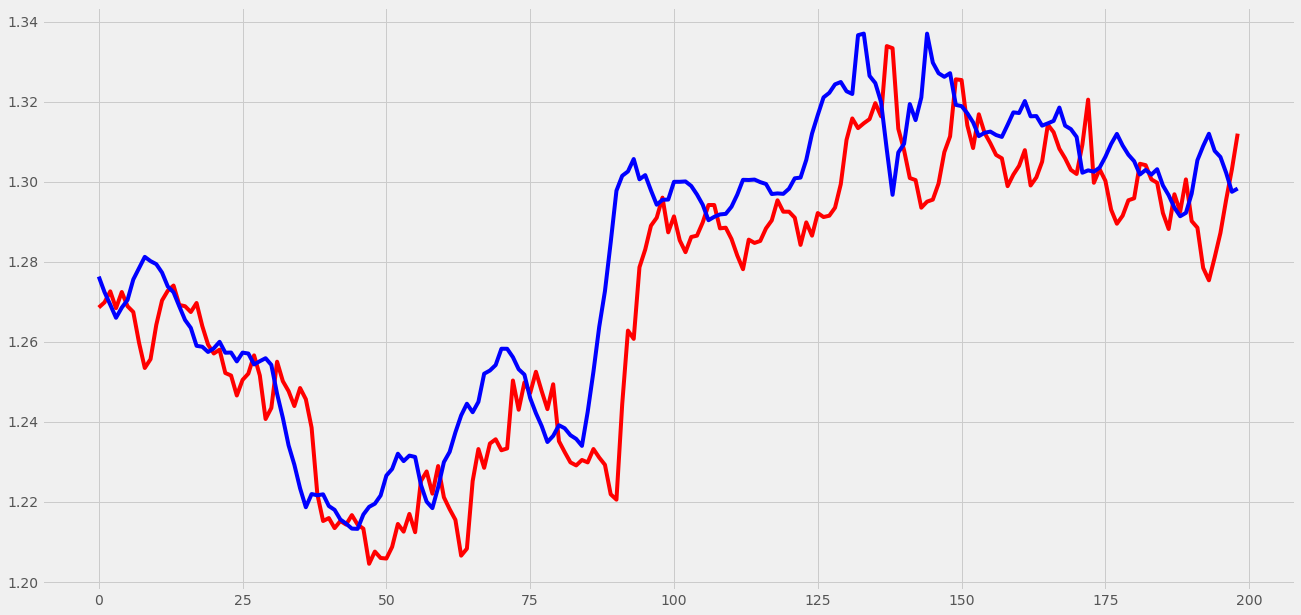

In [601]:
plot(-200,-1)

In [44]:
close = data["rate_close"].values

In [101]:

def profit(days):
    position = 100 #dollars
    
    
    
    split = len(predicted) - days
    trial = predicted[split:]
    dollars = True
    money = []
    for i,rate in enumerate(trial):
        if i==len(trial)-1:
            break
        else:
            #if True -> $ if false -> £
            
            # if USD forecasted to weaken the next day and we're holding dollars -> trade for GBP
            if (trial[i+1] < rate) and dollars:
                #sell them at end of day for current rate
                #in this case we'll just multiply it and convert it
                position *= close[i]
                money += [position]
                dollars = False
                #print('buying pounds')
            # if USD forecasted to strengthen next day and we're holding pounds -> trade for USD
            elif (trial[i+1] > rate) and not dollars:
                position /= close[i]
                dollars = True
                money += [position*close[i]]
                #print('buying dollars')
            # otherwise we're fine
            else:
                money += [position]
                pass
                #print('holding')
            #print(position,dollars)
    return money

'\nfor the next iteration try and implement a 3day view rather than one day\n'

In [102]:
x = profit(100)

In [60]:
returns = {}
for i in range(0,5268):
    returns[i] = profit(i)

In [63]:
df = pd.DataFrame(returns.items(), columns=['days', 'return'])


In [64]:
df.loc[df['return']==df['return'].max()]


,days,return
5267,5267,292.936272


In [68]:
df['percent_return'] = (df['return'] - 100) / 100

In [86]:
df['return'].mean()

99.11350838036782

Text(0.5, 0.98, 'Profitability')

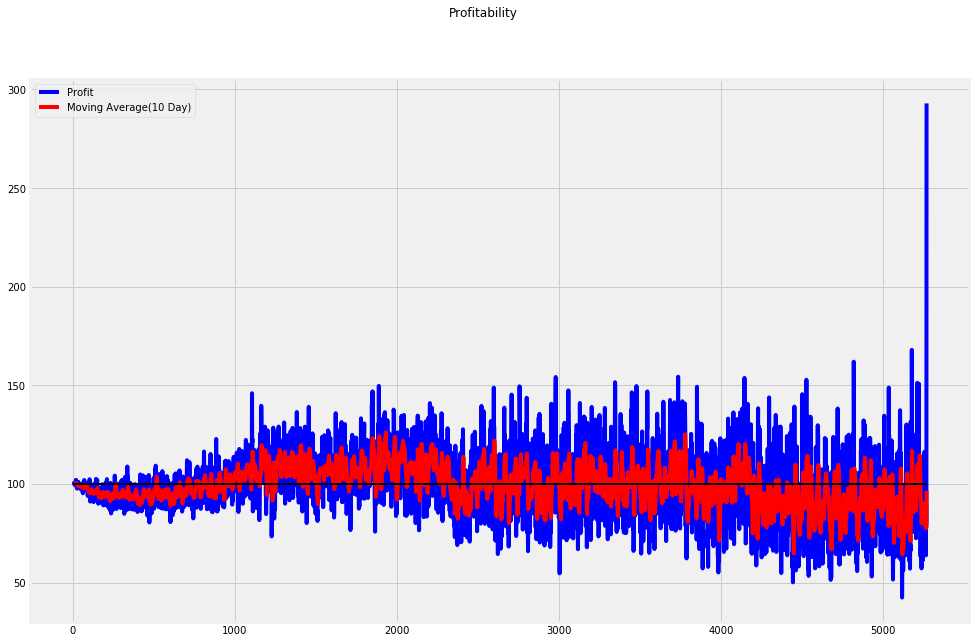

In [89]:
fig, ax = plt.subplots(figsize=(15,10))

plt.plot(df.iloc[:]['return'],c='b')
plt.plot(df.iloc[:]['ma10'],c='r')
plt.plot([0, 5268], [100, 100], color='k', linestyle='-', linewidth=2)
ax.legend(["Profit", "Moving Average(10 Day)"])
plt.suptitle("Profitability")